# La bibliothèque scipy

Le module scipy comporte les sous-modules importants suivants
* scipy.constants : constantes physiques et mathématiques
* scipy.fft : transformée de Fourier discrète
* scipy.integrate : intégration et équations différentielles
* scipy.interpolate : interpolation
* scipy.linalg : algèbre linéaire
* scipy.optimize : optimisation et recherche de racines
* scipy.signal : traitement du signal
* scipy.sparse : matrices creuses
* scipy.stats : fonctions statistiques

## Matrices creuses

Ce sont des matrices comportant beaucoup de zéros. Plusieurs formats existent pour stocker uniquement que
les termes non nuls.

* csc\_matrix : Compressed Sparse Column
* csr\_matrix : Compressed Sparse Row
* bsr\_matrix : Block Sparse Row
* lil\_matrix : List of Lists
* dok\_matrix : Dictionary of Keys
* coo\_matrix : COOrdinate

L'exemple suivant construit une matrice creuse $3 \times 3$ sous forme __CSC__ avec les éléments non nuls suivants :

In [4]:
import numpy as np
import scipy.sparse as sp

row  = np.array([0, 2, 2, 0, 1, 2])
col  = np.array([0, 0, 1, 2, 2, 2])
data = np.array([1, 2, 3, 4, 5, 6])

M = sp.csc_matrix((data, (row, col)), shape=(3, 3))
print(M)
print('-'*20)
print(M.todense())

  (0, 0)	1
  (2, 0)	2
  (2, 1)	3
  (0, 2)	4
  (1, 2)	5
  (2, 2)	6
--------------------
[[1 0 4]
 [0 0 5]
 [2 3 6]]


Chaque colonne est stockée séquentiellement avec les valeurs et indices de ligne correspondants.

### Avantages :
* Opérations arithmétiques efficaces : __csc__ + __csc__, __csc__ * __csc__
* Slicing efficace selon les colonnes
* Produit matrice-vecteur rapide

### Inconvénients :
* Accès aux lignes moins efficace qu'en __csr__
* Conversion coûteuse vers d'autres formats

L'exemple suivant transforme une matrice creuse __csc__ en __csr__

In [5]:
M = sp.csc_matrix((data, (row, col)), shape=(3, 3))
print(type(M))
M = sp.csr_matrix(M) # appel du constructeur
print(type(M))
print(M.getformat()) 
print(M)
print(M.todense())

<class 'scipy.sparse._csc.csc_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>
csr
  (0, 0)	1
  (0, 2)	4
  (1, 2)	5
  (2, 0)	2
  (2, 1)	3
  (2, 2)	6
[[1 0 4]
 [0 0 5]
 [2 3 6]]


In [3]:
## Exemple de création d'une matrice laplacienne
import numpy as np
from scipy.sparse import diags

def laplacien_1D_dirichlet(N, h):
    """
    Génère la matrice du Laplacien 1D discrétisé avec conditions de Dirichlet homogènes.
    
    Paramètres : 
    - N : nombre de points internes (sans les bords)
    - h : pas d'espace (distance entre les points)
      o--|--|--|--|--|--|--|--|--o
    Retourne :
    - L : matrice creuse (sparse) du Laplacien (N x N)
    """
    diagonale = -2 * np.ones(N)
    off_diagonale = np.ones(N - 1)
    data = [off_diagonale, diagonale, off_diagonale]
    offsets = [-1, 0, 1]
    L = diags(data, offsets, format='csr') / h**2
    return L

N = 9   # nombre de points internes
L = 1.0
h = L / (N + 1)  # on inclut les deux points frontières dans le maillage total

A = laplacien_1D_dirichlet(N, h)
print(A.toarray())
print(type(A))
print(A.nnz)

[[-200.  100.    0.    0.    0.    0.    0.    0.    0.]
 [ 100. -200.  100.    0.    0.    0.    0.    0.    0.]
 [   0.  100. -200.  100.    0.    0.    0.    0.    0.]
 [   0.    0.  100. -200.  100.    0.    0.    0.    0.]
 [   0.    0.    0.  100. -200.  100.    0.    0.    0.]
 [   0.    0.    0.    0.  100. -200.  100.    0.    0.]
 [   0.    0.    0.    0.    0.  100. -200.  100.    0.]
 [   0.    0.    0.    0.    0.    0.  100. -200.  100.]
 [   0.    0.    0.    0.    0.    0.    0.  100. -200.]]
<class 'scipy.sparse._csr.csr_matrix'>
25


In [8]:
print(A.nnz)

25


# Modes de vibration d'une corde (voir doc latex)

Le but de l'exercice est de caractériser les modes de vibration $u_k(x)$ selon Oz d'une corde.
Dans la limite des faibles amplitudes de vibration,  ils sont solutions de l'équation d'Helmholtz stationnaire :

$$
\partial_x^2 \; u_k + k^2 \; u_k=0
$$

On considère que la corde est fixée à ses deux extrémités.

### Développement

On vous fournit un embryon de programme ci-dessous  à compléter,
utilisant une classe __Fdm__ pour stocker tous les paramètres de la simulation.

* Compléter la fonction  __\_\_dirichlet__ permettant de construire la liste $ld$ 
des noeuds du bord où sont appliquées la conditions de dirichlet.
On rappelle que
l'instruction ld.append(e) permet d'insérer l'élément e dans la liste ld. 
Utiliser sous Numpy, la fonction ld=numpy.unique(ld) pour éliminer tout doublon dans la liste ld.

* Compléter la fonction  __\_\_build\_K__ permettant de remplir la matrice $K$ pour une grille
de taille $N_x$.
On rappelle que toute ligne $n$ de $K$ correspondant à un noeud
de dirichlet n'est pas remplie. 
Pour tester l'appartenance d'un noeud $n$ dans la liste ld, on utilisera l'expression booléenne
 n in ld. 

* Compléter  la fonction  __solve__ permettant de calculer la $n^{eme}$ plus petite valeur propre
en module ainsi que le mode propre associé. On utilisera la fonction scipy __eigsh__.
Les étapes sont : 
    - construire la matrice P en utilisant la fonction __scipy.sparse.eye__ .
    - Pour la transformer au format CSR, lui appliquer la fonction membre .tocsr()
    - Supprimer les lignes de P dont les indices sont contenus dans self.ld en utilisant la fonction __delete_rows__ fournie.
    - calculer $KP = P K P^t$.
* Pour un système de taille $L=1m$, déterminer les 4 premiers modes de basse énergie et comparer à la solution analytique de l'équation d'Helmholtz. Chercher des solutions de la forme $\sin(k x)$ avec $k = n \frac{\pi}{L}$.


(199, 3)
(199, 3)


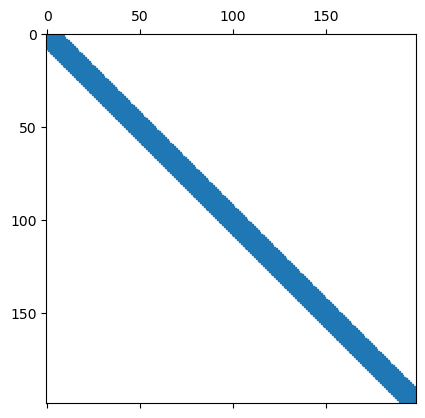

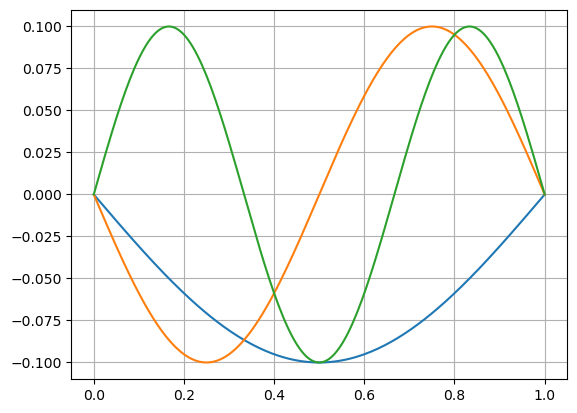

In [3]:
#%matplotlib inline
import scipy
from scipy import sparse
# from scipy.sparse.linalg.dsolve import linsolve
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.pyplot as plt

class Fdm:
    'grille differences finies'
    fdmCount = 0

    def __init__(self, Lx, Nx):
        self.Lx = Lx
        self.Nx = Nx
        self.N  = Nx
        self.dx = Lx/(Nx-1);
        Fdm.fdmCount += 1
   
    def displayCount(self):
        print ("Instances {:d}".format(Fdm.fdmCount)) 
                
    def __dirichlet(self):
        self.ld = [0, self.Nx-1]                  
        self.ld = np.unique(self.ld)

    def __build_K(self):    
        row  = []
        col  = []
        data = []
       
        for ix in range(self.Nx):
            n=ix  
            if n in self.ld: # test d'appartenance
                continue
            else:
                row.append(n)
                col.append(n)
                data.append(2/self.dx**2)
                    
                p=ix+1
                row.append(n)
                col.append(p)
                data.append(-1/self.dx**2)

                p=ix-1
                row.append(n)
                col.append(p)
                data.append(-1/self.dx**2)
                    
        K=sparse.csr_matrix( (data,(row,col)), shape=(self.N, self.N) )
        return K

    def solve(self, n):
        self.__dirichlet();
        K = self.__build_K();
        P=sparse.eye(self.N).tocsr()
        P=delete_rows(P, self.ld)
#        print(self.ld)
#        print('P shape : ', P.shape)      
        Kp=P @ K @ P.T

        # seconde méthode plus efficace en utilisant le slicing
        # all_dofs = range(self.N)
        # free_dofs = [dof for dof in all_dofs if dof not in self.ld]
        # Kp = K[free_dofs, :][:, free_dofs]
        
#        print(Kp.shape)
        plt.figure(1)
        plt.spy(Kp)

        vals, vecs = sparse.linalg.eigsh(Kp, k=n, which='SM')
        print(vecs.shape)
        vecs_full = P.T*vecs
        print(vecs.shape)

        # seconde méthode plus efficace en utilisant le slicing
        # vecs_full = np.zeros(shape=(self.N, n))
        # vecs_full[free_dofs, :] = vecs

        plt.figure(2)
        X = np.linspace(0, self.Lx, num=self.Nx, endpoint=True)
#        print(vecs[:, n-1])
        for i in range(n):
            Y = vecs_full[:, i]
            plt.plot(X, Y)
        plt.grid()
        plt.show()

def delete_rows(mat, indices):
    valid = isinstance(mat, scipy.sparse.lil_matrix) or \
            isinstance(mat, scipy.sparse.csr_matrix)
    if not valid:
        raise ValueError("works only for LIL / CSR format -- use .tolil() / .tocsr() first")
    indices = list(indices)
    mask = np.ones(mat.shape[0], dtype=bool)
    mask[indices] = False
    return mat[mask]


fdm = Fdm(1.0, 201)
fdm.solve(3)


(62, 5)
(62, 5)


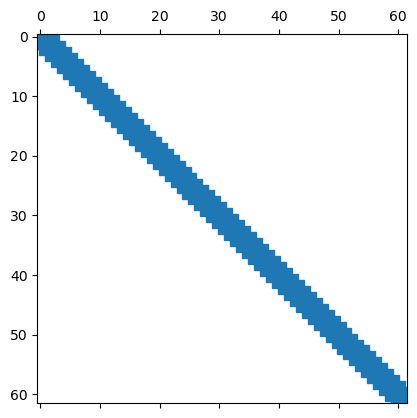

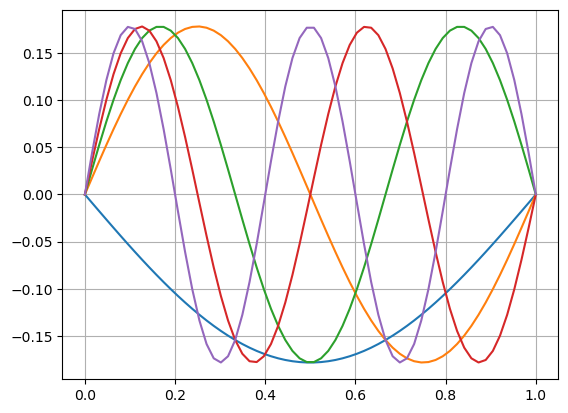

In [2]:
#%matplotlib inline
import scipy
from scipy import sparse
# from scipy.sparse.linalg.dsolve import linsolve
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.pyplot as plt

class Fdm:
    'grille differences finies'
    fdmCount = 0

    def __init__(self, Lx, Nx):
        self.Lx = Lx
        self.Nx = Nx
        self.N  = Nx
        self.dx = Lx/(Nx-1);
        Fdm.fdmCount += 1
   
    def displayCount(self):
        print ("Instances {:d}".format(Fdm.fdmCount)) 
                
    def __dirichlet(self):
        self.ld = [0, self.Nx-1]                  
        self.ld = np.unique(self.ld)

    def __build_K(self):    
        row  = []
        col  = []
        data = []

        D=2/self.dx**2;        
        for ix in range(self.Nx):
            n=ix  
            if n in self.ld: # test d'appartenance
                continue
            else:
                row.append(n)
                col.append(n)
                data.append(D)
                    
                p=ix+1
                row.append(n)
                col.append(p)
                data.append(-1/self.dx**2)

                p=ix-1
                row.append(n)
                col.append(p)
                data.append(-1/self.dx**2)
                    
        K=sparse.csr_matrix( (data,(row,col)), shape=(self.N, self.N) )
        return K

    def solve(self, n):
        self.__dirichlet();
        K = self.__build_K();
        UN= np.ones(self.N)
        P=sparse.diags(UN).tocsr()
        P=delete_rows(P, self.ld)
#        print(fdm.ld)
#        print('P shape : ', P.shape)      
        Kp=P @ K @ P.T

        # seconde méthode plus efficace en utilisant le slicing
        all_dofs = range(self.N)
        free_dofs = [x for x in all_dofs if x not in self.ld]
        Kp = K[free_dofs, :][:, free_dofs]
        
#        print(Kp.shape)
        plt.figure(1)
        plt.spy(Kp)

        vals, vecs = sparse.linalg.eigsh(Kp, k=n, which='SM')
        print(vecs.shape)
        vecs_full = P.T*vecs
        print(vecs.shape)

        vecs_full = np.zeros(shape=(self.N, n))
        vecs_full[free_dofs, :] = vecs

        plt.figure(2)
        X = np.linspace(0, self.Lx, num=self.Nx, endpoint=True)
#        print(vecs[:, n-1])
        for i in range(n):
            Y = vecs_full[:, i]
            plt.plot(X, Y)
        plt.grid()
        plt.show()

def delete_rows(mat, indices):
    valid = isinstance(mat, scipy.sparse.lil_matrix) or \
            isinstance(mat, scipy.sparse.csr_matrix)
    if not valid:
        raise ValueError("works only for LIL / CSR format -- use .tolil() / .tocsr() first")
    indices = list(indices)
    mask = np.ones(mat.shape[0], dtype=bool)
    mask[indices] = False
    return mat[mask]


fdm = Fdm(1.0, 64)
fdm.solve(5)
